### A MCMC implementation for a Bayesian Poisson Regression

#### **Model Setup**

- **Data:** Counts $y_i \in \{0, 1, 2, \dots\}$ and predictors $X_i$ for $i = 1, \dots, n$.
- **Model:** Poisson regression (log-linear model)
  $$
  y_i \sim \text{Poisson}(\lambda_i), \quad \log \lambda_i = X_i \beta
  $$
  where $X_i$ is the vector of predictors for observation $i$, and $\beta$ is the vector of regression coefficients.

---

#### **Likelihood**

The likelihood for the observed data, given $\beta$ and $X$, is based on the Poisson Probability Mass Function (PMF) since this is a discrete distribution:

$$
p(\mathbf{y} | \beta, X) = \prod_{i=1}^n \frac{e^{-\lambda_i} \lambda_i^{y_i}}{y_i!}
$$
where $\lambda_i = \exp(X_i \beta)$.

The **log-likelihood**:
$$
\log p(\mathbf{y} | \beta, X) = \sum_{i=1}^n \left( y_i (X_i\beta) - \exp(X_i\beta) \right) + \text{const}
$$

---

#### **Prior**

A multivariate normal (Gaussian) prior is placed on $\beta$:
$$
\beta \sim \mathcal{N}(\mu_0, \Sigma_0)
$$
where:
- $\mu_0$ is the prior mean vector (often zeros),
- $\Sigma_0$ is the prior covariance matrix.

The prior density is:
$$
p(\beta) = \frac{1}{(2\pi)^{p/2} |\Sigma_0|^{1/2}} \exp\left(-\frac{1}{2} (\beta - \mu_0)^\top \Sigma_0^{-1} (\beta - \mu_0)\right)
$$

---

#### **Posterior**

The posterior combines likelihood and prior:
$$
p(\beta | \mathbf{y}, X) \propto p(\mathbf{y} | \beta, X) \cdot p(\beta)
$$

---

#### **Metropolis-Hastings Algorithm Steps in the Code**

1. **Initialization (Frequentist/ML):**
   - The chain starts at the MLE from a standard Poisson GLM fit.

2. **Proposal Step:**
   - Propose $\beta^*$ from a multivariate normal centered at the current value:
     $$
     \beta^* \sim \mathcal{N}(\beta^{(t-1)}, \delta V)
     $$
     where $V$ is an estimate of the covariance matrix from the frequentist fit and $\delta$ is a tuning parameter.

3. **Acceptance Ratio:**
   - Compute the log of the Metropolis-Hastings acceptance ratio:
     $$
     \log R = \left[ \log p(\mathbf{y} | \beta^*, X) + \log p(\beta^*) \right] - \left[ \log p(\mathbf{y} | \beta^{(t-1)}, X) + \log p(\beta^{(t-1)}) \right]
     $$
   - Accept $\beta^*$ with probability $\min(1, \exp(\log R))$.

4. **Update Step:**
   - If accepted, set $\beta^{(t)} = \beta^*$; otherwise, set $\beta^{(t)} = \beta^{(t-1)}$.
   - Repeat for `nIter` iterations (with multiple chains if desired), discarding `nBurnIn` as burn-in.

#### Additional chains

The code below also implements multiple independent Markov Chains. This is standard practice in Bayesian estimation so parameter convergence can be validated across multiple chains besides inside a single chain.


In [1]:
import numpy as np
from scipy.stats import multivariate_normal, gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [2]:
def pois_loglik(beta, y, X):
    """
    Computes log-likelihood for a Poisson log-linear model
    beta: shape (,p)
    y: integer-valued response
    X: design matrix of covariates
    Returns: log-likelihood
    """
    beta = np.atleast_2d(beta)
    n_chain = beta.shape[0]
    pll = np.zeros(n_chain)

    for i in range(n_chain):
        mu = X @ beta[i]
        pll[i] = np.sum(mu * y - np.exp(mu))

    return pll if n_chain > 1 else pll[0]
    # end of log-likelihood function

def MHpoisGLM(y, X, nIter, nBurnIn, delta, nChains=2, plot=True):
    if nIter <= nBurnIn:
        raise ValueError("Number of warm-up iterations must be smaller than total iterations.")

    n, p = X.shape
    # Frequentist init
    poisson_mod = sm.GLM(y, X, family=sm.families.Poisson())
    freqMod = poisson_mod.fit()
    beta_start = freqMod.params
    variance = freqMod.cov_params()

    # Prepare chains
    chains = [np.zeros((nIter, p)) for _ in range(nChains)]
    for chain in chains:
        chain[0] = beta_start

    # Run chains
    for c in range(nChains):
        for i in range(1, nIter):
            beta_hat = multivariate_normal.rvs(mean=chains[c][i-1], cov=delta * variance)
            logR = pois_loglik(beta_hat, y, X) - pois_loglik(chains[c][i-1], y, X)
            if np.random.uniform() <= np.exp(logR):
                chains[c][i] = beta_hat
            else:
                chains[c][i] = chains[c][i-1]

    # Remove burn-in
    chains_post = [chain[nBurnIn:] for chain in chains]

    # Posterior summaries (for chain 1)
    param_names = [f'alpha'] + [f'beta{j}' for j in range(1, p)]
    summary = pd.DataFrame({
        'Parameter': param_names,
        'Median': np.median(chains_post[0], axis=0),
        'SD': np.std(chains_post[0], axis=0)
    })

    # Plotting
    if plot:
        fig, axs = plt.subplots(2, p, figsize=(4*p, 8))
        colors = ['black', '#FF000088', 'blue', 'green', 'orange', 'purple']
        # Traceplots
        for j in range(p):
            for c in range(nChains):
                axs[0, j].plot(chains_post[c][:, j], color=colors[c % len(colors)], alpha=0.7, label=f"Chain {c+1}" if j == 0 else None)
            axs[0, j].set_title(f'Trace: beta{j}' if j > 0 else 'Trace: alpha')
            if j == 0:
                axs[0, j].legend()
        # Density plots
        for j in range(p):
            for c in range(nChains):
                kde = gaussian_kde(chains_post[c][:, j])
                x_vals = np.linspace(np.min(chains_post[c][:, j]), np.max(chains_post[c][:, j]), 200)
                axs[1, j].plot(x_vals, kde(x_vals), color=colors[c % len(colors)], label=f"Chain {c+1}")
            axs[1, j].set_title(f'Density: beta{j}' if j > 0 else 'Density: alpha')
            axs[1, j].legend()
        plt.tight_layout()
        plt.show()

    # Prepare output
    chains_post_df = [pd.DataFrame(chain, columns=param_names) for chain in chains_post]
    output = {
        'posteriorSummary': summary,
        'chains': chains_post_df
    }
    return output

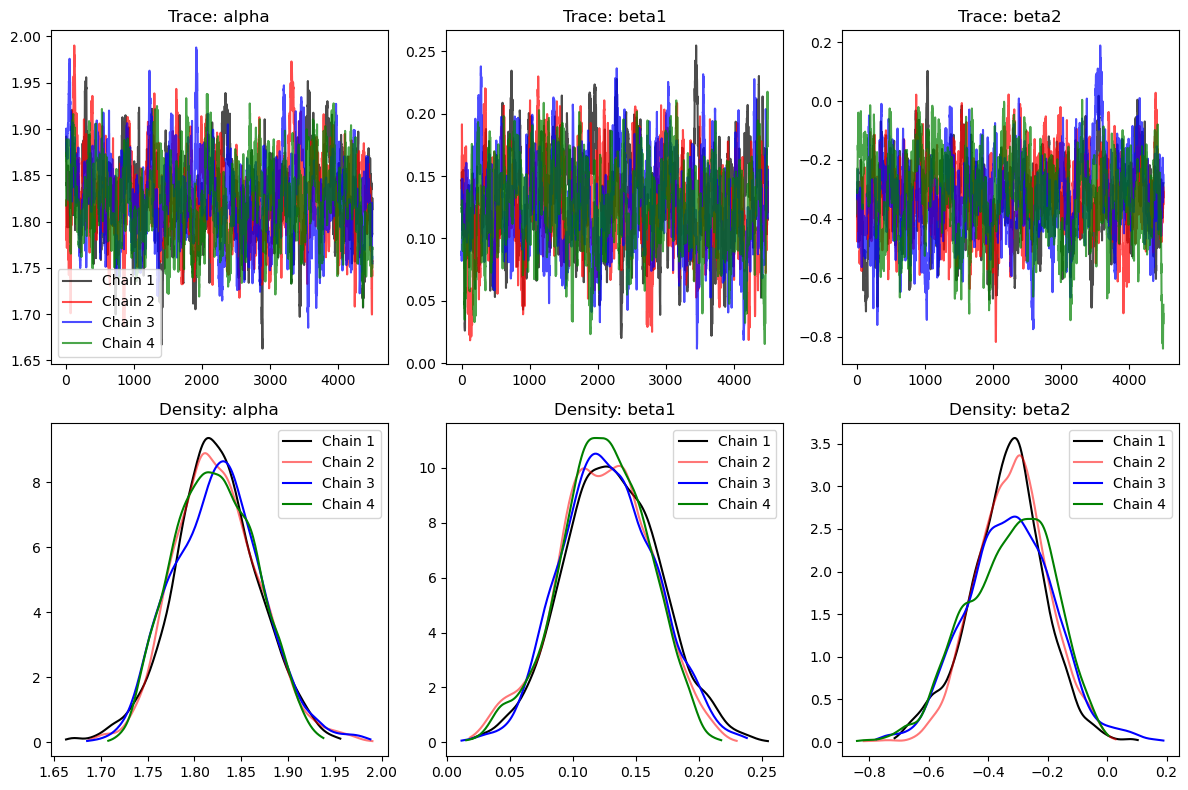

  Parameter    Median        SD
0     alpha  1.822162  0.044790
1     beta1  0.130396  0.037623
2     beta2 -0.330679  0.124747


In [3]:
# Example usage:
np.random.seed(444)
B0 =  1.2   # intercept
B1 =  1.5   # slope for x1
B2 = -0.5   # slope for x2

y = np.random.poisson(6.5, 100)
x2 = np.linspace(-0.5, 0.5, len(y))
x1 = (np.log(y+1e-2) - B0 - B2 * x2) / B1 + np.random.normal(0, 1, size=len(y))
X = np.column_stack([np.ones(len(y)), x1, x2])

result = MHpoisGLM(y = y, X = X, nIter = 10000, nBurnIn = 1000, delta = 0.1, nChains = 4, plot = True)
print(result['posteriorSummary'])